# Puzzle Solver 🧩

In [1]:
# Don't worry about it it just used for easier coding:
import os
import glob 

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# path of dataset change with your own path
folder_path = r"D:\techstack2025-ai\week1\task\images_part2\Puzzle_1_40"

In [3]:
#Read Images
output_file = os.path.join(folder_path, "Output.tif")
patch_files = glob.glob(os.path.join(folder_path, "Patch_*.tif"))

corners_img = np.array(Image.open(output_file))
# Get copy of image to edit it later
base_img = corners_img.copy()

patches = [np.array(Image.open(patch_file)) for patch_file in patch_files]

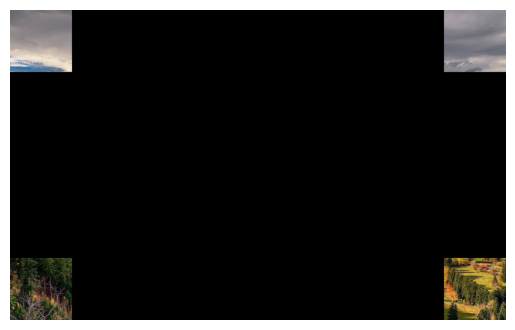

In [4]:
plt.imshow(base_img)
plt.axis('off')
plt.show()

In [31]:
rows, cols = 5, 8
img_width, img_height = 1920, 1200
patch_width, patch_height = img_width // cols, img_height // rows

def puzzle_solver():
    def get_edge_dissimilarity(p1_idx, p2_idx, direction):
        piece1 = patches[p1_idx]
        piece2 = patches[p2_idx]
        
        if direction == 'right':
            edge1, edge2 = piece1[:, -1], piece2[:, 0]
        elif direction == 'left':
            edge1, edge2 = piece1[:, 0], piece2[:, -1]
        elif direction == 'down':
            edge1, edge2 = piece1[-1, :], piece2[0, :]
        elif direction == 'up':
            edge1, edge2 = piece1[0, :], piece2[-1, :]
        else:
            return float('inf')
        
        return np.sum((edge1.astype(float) - edge2.astype(float))**2)

    def find_corner_piece():
        min_score = float('inf')
        corner_idx = -1
        for idx in range(len(patches)):
            left_match = min(get_edge_dissimilarity(idx, j, 'left') for j in range(len(patches)) if j != idx)
            up_match   = min(get_edge_dissimilarity(idx, j, 'up')   for j in range(len(patches)) if j != idx)
            score = left_match + up_match
            if score < min_score:
                min_score = score
                corner_idx = idx
        return corner_idx

    
    puzzle_grid = np.full((rows, cols), -1, dtype=int)
    available_indices = set(range(len(patches)))

    
    first_piece_idx = find_corner_piece()
    puzzle_grid[0, 0] = first_piece_idx
    available_indices.remove(first_piece_idx)

    for r in range(rows):
        for c in range(cols):
            if puzzle_grid[r, c] != -1:
                continue

            best_so_far = {'min_error': float('inf'), 'index': -1}
            for idx in available_indices:
                error = 0
                neighbor_count = 0

                if c > 0 and puzzle_grid[r, c-1] != -1:
                    error += get_edge_dissimilarity(puzzle_grid[r, c-1], idx, 'right')
                    neighbor_count += 1

                if r > 0 and puzzle_grid[r-1, c] != -1:
                    error += get_edge_dissimilarity(puzzle_grid[r-1, c], idx, 'down')
                    neighbor_count += 1

                if neighbor_count > 0:
                    avg_error = error / neighbor_count
                    if avg_error < best_so_far['min_error']:
                        best_so_far['min_error'] = avg_error
                        best_so_far['index'] = idx

            if best_so_far['index'] != -1:
                puzzle_grid[r, c] = best_so_far['index']
                available_indices.remove(best_so_far['index'])

    final_img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for r in range(rows):
        for c in range(cols):
            piece_idx = puzzle_grid[r, c]
            if piece_idx != -1:
                y1, y2 = r * patch_height, (r + 1) * patch_height
                x1, x2 = c * patch_width, (c + 1) * patch_width
                final_img[y1:y2, x1:x2] = patches[piece_idx]
    return final_img

In [32]:
# Test and Save final Image
final_img = puzzle_solver()
Image.fromarray(final_img).save(os.path.join(folder_path, "final.tif"))

In [33]:
# Now it's time to find what's our final image good base on original image

# This properties are determined according to the dataset:
rows, cols = 5, 8
img_width, img_height = 1920, 1200
patch_width, patch_height = img_width // cols, img_height // rows

def accuracy_block_base(original_img, final_img, rows, cols):
    correct_blocks = 0
    total_blocks = rows * cols 
    for row in range(rows):
        for col in range(cols):
            patch = final_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]
            original_patch = original_img[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width]

            if np.array_equal(patch, original_patch):
                correct_blocks += 1
    
    return 100 * correct_blocks / total_blocks

original_img = np.array(Image.open(os.path.join(folder_path, "Original.tif")))
accuracy= accuracy_block_base(original_img, final_img, rows, cols)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 10.00%


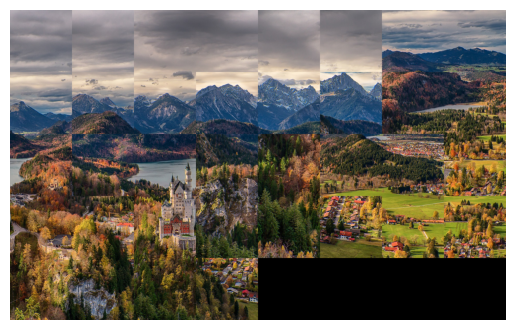

In [27]:
# show final_img - You can make animation for it while solving puzzle. That's fun!
plt.imshow(final_img)
plt.axis('off') 
plt.show()

In [28]:
rows, cols = 5, 8
img_width, img_height = 1920, 1200
patch_width, patch_height = img_width // cols, img_height // rows
def puzzle_solver():
    def find_best_match_for_area(target_patch, available_idx):
        best_diff_so_far = float('inf')
        best_idx_so_far = -1
        for i in available_idx:
            patch = patches[i]
            diff = np.sum((target_patch.astype(float) - patch.astype(float))**2)
            if diff < best_diff_so_far:
                best_diff_so_far = diff
                best_idx_so_far = i
        return best_idx_so_far

    def get_edge_dissimilarity(p1_idx, p2_idx, p1_edge_direction):
        piece1 = patches[p1_idx]
        piece2 = patches[p2_idx]
        
        if p1_edge_direction == 'right': 
            edge1, edge2 = piece1[:, -1], piece2[:, 0]
        elif p1_edge_direction == 'left': 
            edge1, edge2 = piece1[:, 0], piece2[:, -1]
        elif p1_edge_direction == 'down': 
            edge1, edge2 = piece1[-1, :], piece2[0, :]
        elif p1_edge_direction == 'up':  
            edge1, edge2 = piece1[0, :], piece2[-1, :]
        else:
            return float('inf')

        return np.sum((edge1.astype(float) - edge2.astype(float))**2)

    puzzle_grid = np.full((rows, cols), -1, dtype=int)
    available_indices = set(range(len(patches))) 
    
    up_left = base_img[0:patch_height, 0:patch_width]
    up_left_idx = find_best_match_for_area(up_left, available_indices)
    puzzle_grid[0, 0] = up_left_idx
    available_indices.remove(up_left_idx)

    up_right = base_img[0:patch_height, (cols - 1) * patch_width:cols * patch_width]
    up_right_idx = find_best_match_for_area(up_right, available_indices)
    puzzle_grid[0, cols - 1] = up_right_idx
    available_indices.remove(up_right_idx)

    down_left = base_img[(rows - 1) * patch_height:rows * patch_height, 0:patch_width]
    down_left_idx = find_best_match_for_area(down_left, available_indices)
    puzzle_grid[rows - 1, 0] = down_left_idx
    available_indices.remove(down_left_idx)

    down_right = base_img[(rows - 1) * patch_height:rows * patch_height, (cols - 1) * patch_width:cols * patch_width]
    down_right_idx = find_best_match_for_area(down_right, available_indices)
    puzzle_grid[rows - 1, cols - 1] = down_right_idx
    available_indices.remove(down_right_idx)
    
    while len(available_indices) > 0:
        best_so_far = {'min_error': float('inf'), 'index': -1, 'position': None}
        
        for r in range(rows):
            for c in range(cols):
                if puzzle_grid[r, c] != -1:
                    continue 
                    
                for index in available_indices:
                    error = 0
                    neighbor_count = 0
                    
                    if c > 0 and puzzle_grid[r, c - 1] != -1:
                        neighbor_idx = puzzle_grid[r, c - 1]
                        error += get_edge_dissimilarity(neighbor_idx, index, 'right')
                        neighbor_count += 1
                        
                    if r > 0 and puzzle_grid[r - 1, c] != -1:
                        neighbor_idx = puzzle_grid[r - 1, c]
                        error += get_edge_dissimilarity(neighbor_idx, index, 'down')
                        neighbor_count += 1
                    
                    if c < cols - 1 and puzzle_grid[r, c + 1] != -1:
                        neighbor_idx = puzzle_grid[r, c + 1]
                        error += get_edge_dissimilarity(neighbor_idx, index, 'left')
                        neighbor_count += 1

                    if r < rows - 1 and puzzle_grid[r + 1, c] != -1:
                        neighbor_idx = puzzle_grid[r + 1, c]
                        error += get_edge_dissimilarity(neighbor_idx, index, 'up')
                        neighbor_count += 1
                   
                    if neighbor_count > 0:
                        avg_error = error / neighbor_count
                        if avg_error < best_so_far['min_error']:
                            best_so_far['min_error'] = avg_error
                            best_so_far['index'] = index
                            best_so_far['position'] = (r, c)
    
        if best_so_far['index'] != -1:
            row, col = best_so_far['position']
            piece_to_place_idx = best_so_far['index']
            puzzle_grid[row, col] = piece_to_place_idx
            available_indices.remove(piece_to_place_idx)
        else:
            break

    final_img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for r in range(rows):
        for c in range(cols):
            piece_idx = puzzle_grid[r, c]
            if piece_idx != -1:
                y1, y2 = r * patch_height, (r + 1) * patch_height
                x1, x2 = c * patch_width, (c + 1) * patch_width
                final_img[y1:y2, x1:x2] = patches[piece_idx]
    return final_img